In [1]:
#import essential libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchvision import models
import os
import pandas as pd
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import time
import copy
from tqdm import tqdm
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import pdb

In [2]:
#%automatic reloading during training
%load_ext autoreload
%autoreload 2

In [3]:
# set seed for  reproduciblity of the code
random_seed = 2023 # or any of your favorite number 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [4]:
# Set the device, check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
#define a custom class from my dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = {'MS': 1, 'noMS': 0}
        self.data = self.load_data()
        random.shuffle(self.data)  # Shuffle the data upon initialization

    def load_data(self):
        data = []

        for class_name, class_label in self.classes.items():
            class_path = os.path.join(self.root_dir, class_name)

            for filename in os.listdir(class_path):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(class_path, filename)
                    data.append((img_path, class_label))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = CustomDataset(root_dir='C:\\Users\\hajami\\Desktop\\535-data', transform=transform)


In [6]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust the size as needed
    transforms.ToTensor(),
])
dataset = CustomDataset(root_dir='C:\\Users\\hajami\\Desktop\\535-data', transform=transform)

In [9]:
#split the dataset 
from torch.utils.data import random_split

# Split the dataset into train, validation, and test sets
train_size = int(0.70 * len(dataset))
val_size = int(0.20 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Corrected calculation

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Access the individual datasets
print(len(train_data))  # Number of samples in the training set
print(len(val_data))    # Number of samples in the validation set
print(len(test_data))   # Number of samples in the test set

21420
6120
3060


In [10]:
#define the dataloader for training and testing loops
from torch.utils.data import DataLoader

train_len = len(train_data)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

val_len = len(val_data)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)

test_len = len(test_data)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

data_loaders = {'train':train_dataloader, 'val':val_dataloader}

In [11]:
classes = train_data.dataset.classes

In [12]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


In [13]:
print(torch.cuda.is_available())

True


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
train_loss =  []
train_acc = []
val_loss = []
val_acc = []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(train_dataloader)
    val_batches = len(val_dataloader)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        for data in tqdm(train_dataloader):
            
                
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
        
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train / train_len
        avg_acc = acc_train / train_len
        train_loss.append(avg_loss)
        train_acc.append(avg_acc)
        
        model.train(False)
        model.eval()
            
        for data in tqdm(val_dataloader):
                
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / val_len
        avg_acc_val = acc_val / val_len
        
        val_loss.append(avg_loss_val)
        val_acc.append(avg_acc_val)
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
        #scheduler.step(avg_loss_val)
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [16]:
train_len, val_len, test_len

(21420, 6120, 3060)

In [17]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2, bias=True)
model.to(device)

for param in model.parameters():
    param.requires_grad = False
    
for param in model.fc.parameters():
    param.requires_grad = True

for param in model.layer4[1].parameters():
    param.requires_grad = True


model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0000001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

C:\Users\hajami\AppData\Local\anaconda3\envs\Hanieh_second_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hajami\AppData\Local\anaconda3\envs\Hanieh_second_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
train_model(model, criterion, optimizer, scheduler, num_epochs=40)

Epoch 0/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 12.93it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 12.99it/s]



Epoch 0 result: 
Avg loss (train): 0.0217
Avg acc (train): 0.5752
Avg loss (val): 0.0207
Avg acc (val): 0.6163
----------

Epoch 1/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 13.06it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.18it/s]



Epoch 1 result: 
Avg loss (train): 0.0198
Avg acc (train): 0.6434
Avg loss (val): 0.0190
Avg acc (val): 0.6838
----------

Epoch 2/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 12.93it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.21it/s]



Epoch 2 result: 
Avg loss (train): 0.0183
Avg acc (train): 0.7013
Avg loss (val): 0.0179
Avg acc (val): 0.7152
----------

Epoch 3/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 13.02it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.04it/s]



Epoch 3 result: 
Avg loss (train): 0.0171
Avg acc (train): 0.7449
Avg loss (val): 0.0165
Avg acc (val): 0.7681
----------

Epoch 4/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.22it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:15<00:00, 12.09it/s]



Epoch 4 result: 
Avg loss (train): 0.0160
Avg acc (train): 0.7771
Avg loss (val): 0.0157
Avg acc (val): 0.7895
----------

Epoch 5/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:55<00:00, 12.17it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.36it/s]



Epoch 5 result: 
Avg loss (train): 0.0152
Avg acc (train): 0.8001
Avg loss (val): 0.0147
Avg acc (val): 0.8170
----------

Epoch 6/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 12.95it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.00it/s]



Epoch 6 result: 
Avg loss (train): 0.0144
Avg acc (train): 0.8189
Avg loss (val): 0.0140
Avg acc (val): 0.8281
----------

Epoch 7/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:56<00:00, 11.83it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.33it/s]



Epoch 7 result: 
Avg loss (train): 0.0137
Avg acc (train): 0.8317
Avg loss (val): 0.0135
Avg acc (val): 0.8412
----------

Epoch 8/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:52<00:00, 12.81it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.56it/s]



Epoch 8 result: 
Avg loss (train): 0.0131
Avg acc (train): 0.8428
Avg loss (val): 0.0127
Avg acc (val): 0.8520
----------

Epoch 9/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 12.97it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.19it/s]



Epoch 9 result: 
Avg loss (train): 0.0126
Avg acc (train): 0.8506
Avg loss (val): 0.0123
Avg acc (val): 0.8583
----------

Epoch 10/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.16it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.26it/s]



Epoch 10 result: 
Avg loss (train): 0.0121
Avg acc (train): 0.8579
Avg loss (val): 0.0118
Avg acc (val): 0.8673
----------

Epoch 11/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 12.96it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.03it/s]



Epoch 11 result: 
Avg loss (train): 0.0117
Avg acc (train): 0.8643
Avg loss (val): 0.0114
Avg acc (val): 0.8711
----------

Epoch 12/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.19it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.39it/s]



Epoch 12 result: 
Avg loss (train): 0.0113
Avg acc (train): 0.8692
Avg loss (val): 0.0110
Avg acc (val): 0.8758
----------

Epoch 13/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:52<00:00, 12.81it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.06it/s]



Epoch 13 result: 
Avg loss (train): 0.0109
Avg acc (train): 0.8756
Avg loss (val): 0.0107
Avg acc (val): 0.8848
----------

Epoch 14/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.17it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.35it/s]



Epoch 14 result: 
Avg loss (train): 0.0106
Avg acc (train): 0.8783
Avg loss (val): 0.0103
Avg acc (val): 0.8886
----------

Epoch 15/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:52<00:00, 12.78it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 12.99it/s]



Epoch 15 result: 
Avg loss (train): 0.0104
Avg acc (train): 0.8802
Avg loss (val): 0.0100
Avg acc (val): 0.8920
----------

Epoch 16/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.17it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.30it/s]



Epoch 16 result: 
Avg loss (train): 0.0101
Avg acc (train): 0.8837
Avg loss (val): 0.0099
Avg acc (val): 0.8941
----------

Epoch 17/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:52<00:00, 12.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.12it/s]



Epoch 17 result: 
Avg loss (train): 0.0099
Avg acc (train): 0.8872
Avg loss (val): 0.0096
Avg acc (val): 0.8984
----------

Epoch 18/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:49<00:00, 13.41it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.37it/s]



Epoch 18 result: 
Avg loss (train): 0.0096
Avg acc (train): 0.8909
Avg loss (val): 0.0092
Avg acc (val): 0.9013
----------

Epoch 19/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 13.06it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.15it/s]



Epoch 19 result: 
Avg loss (train): 0.0094
Avg acc (train): 0.8951
Avg loss (val): 0.0091
Avg acc (val): 0.9008
----------

Epoch 20/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 13.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.15it/s]



Epoch 20 result: 
Avg loss (train): 0.0092
Avg acc (train): 0.8980
Avg loss (val): 0.0090
Avg acc (val): 0.9025
----------

Epoch 21/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.30it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.30it/s]



Epoch 21 result: 
Avg loss (train): 0.0090
Avg acc (train): 0.9009
Avg loss (val): 0.0086
Avg acc (val): 0.9072
----------

Epoch 22/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.17it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.29it/s]



Epoch 22 result: 
Avg loss (train): 0.0089
Avg acc (train): 0.9004
Avg loss (val): 0.0084
Avg acc (val): 0.9096
----------

Epoch 23/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.23it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.39it/s]



Epoch 23 result: 
Avg loss (train): 0.0087
Avg acc (train): 0.9004
Avg loss (val): 0.0085
Avg acc (val): 0.9046
----------

Epoch 24/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.22it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.24it/s]



Epoch 24 result: 
Avg loss (train): 0.0085
Avg acc (train): 0.9059
Avg loss (val): 0.0081
Avg acc (val): 0.9147
----------

Epoch 25/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 12.96it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.18it/s]



Epoch 25 result: 
Avg loss (train): 0.0084
Avg acc (train): 0.9056
Avg loss (val): 0.0080
Avg acc (val): 0.9170
----------

Epoch 26/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.29it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.30it/s]



Epoch 26 result: 
Avg loss (train): 0.0082
Avg acc (train): 0.9067
Avg loss (val): 0.0079
Avg acc (val): 0.9190
----------

Epoch 27/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 12.93it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.22it/s]



Epoch 27 result: 
Avg loss (train): 0.0081
Avg acc (train): 0.9090
Avg loss (val): 0.0078
Avg acc (val): 0.9191
----------

Epoch 28/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.29it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.35it/s]



Epoch 28 result: 
Avg loss (train): 0.0080
Avg acc (train): 0.9120
Avg loss (val): 0.0077
Avg acc (val): 0.9186
----------

Epoch 29/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.27it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.37it/s]



Epoch 29 result: 
Avg loss (train): 0.0078
Avg acc (train): 0.9120
Avg loss (val): 0.0075
Avg acc (val): 0.9237
----------

Epoch 30/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 12.92it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.16it/s]



Epoch 30 result: 
Avg loss (train): 0.0077
Avg acc (train): 0.9137
Avg loss (val): 0.0073
Avg acc (val): 0.9248
----------

Epoch 31/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.23it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.43it/s]



Epoch 31 result: 
Avg loss (train): 0.0076
Avg acc (train): 0.9155
Avg loss (val): 0.0075
Avg acc (val): 0.9181
----------

Epoch 32/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.20it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.35it/s]



Epoch 32 result: 
Avg loss (train): 0.0075
Avg acc (train): 0.9170
Avg loss (val): 0.0072
Avg acc (val): 0.9263
----------

Epoch 33/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 12.89it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.02it/s]



Epoch 33 result: 
Avg loss (train): 0.0074
Avg acc (train): 0.9164
Avg loss (val): 0.0069
Avg acc (val): 0.9296
----------

Epoch 34/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.26it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.38it/s]



Epoch 34 result: 
Avg loss (train): 0.0073
Avg acc (train): 0.9190
Avg loss (val): 0.0070
Avg acc (val): 0.9250
----------

Epoch 35/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.34it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.23it/s]



Epoch 35 result: 
Avg loss (train): 0.0072
Avg acc (train): 0.9227
Avg loss (val): 0.0068
Avg acc (val): 0.9312
----------

Epoch 36/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 12.92it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.15it/s]



Epoch 36 result: 
Avg loss (train): 0.0072
Avg acc (train): 0.9205
Avg loss (val): 0.0068
Avg acc (val): 0.9296
----------

Epoch 37/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:51<00:00, 12.90it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.14it/s]



Epoch 37 result: 
Avg loss (train): 0.0070
Avg acc (train): 0.9209
Avg loss (val): 0.0066
Avg acc (val): 0.9337
----------

Epoch 38/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.30it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.36it/s]



Epoch 38 result: 
Avg loss (train): 0.0069
Avg acc (train): 0.9228
Avg loss (val): 0.0066
Avg acc (val): 0.9320
----------

Epoch 39/40
----------


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:50<00:00, 13.27it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:14<00:00, 13.49it/s]


Epoch 39 result: 
Avg loss (train): 0.0069
Avg acc (train): 0.9245
Avg loss (val): 0.0065
Avg acc (val): 0.9351
----------


Training completed in 43m 59s
Best acc: 0.9351


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

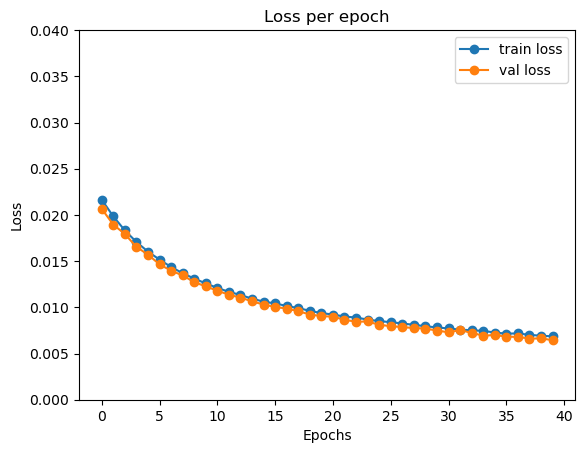

In [20]:
# Your existing code to plot the losses
fig_loss, ax_loss = plt.subplots()
ax_loss.plot(train_loss, label='train loss', marker='o')
ax_loss.plot(val_loss, label='val loss', marker='o')
ax_loss.legend()
ax_loss.set_title('Loss per epoch')
ax_loss.set_xlabel('Epochs')
ax_loss.set_ylabel('Loss')

# Customize y-axis limits from 0 to 0.06
ax_loss.set_ylim(0, 0.04)

# Set x-axis ticks and labels
num_epochs = len(train_loss)
ax_loss.set_xticks(range(0, num_epochs + 1, 5))  # Set ticks at intervals of 5
ax_loss.set_xticklabels(range(0, num_epochs + 1, 5))  # Set labels corresponding to the ticks

plt.show()


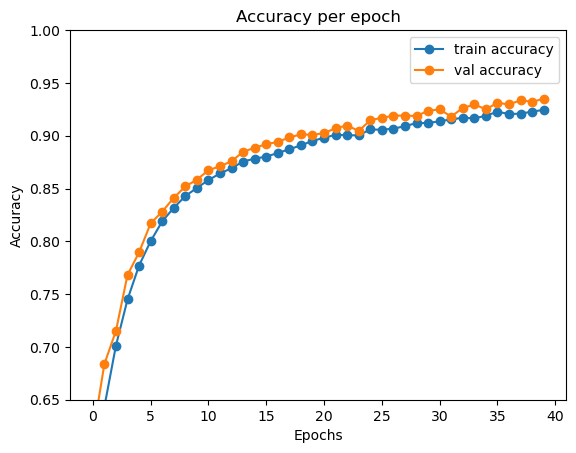

In [21]:

# Move tensors to CPU and extract values for plotting
train_acc_cpu = [acc.cpu().item() for acc in train_acc]
val_acc_cpu = [acc.cpu().item() for acc in val_acc]

fig_acc, ax_acc = plt.subplots()
ax_acc.plot(train_acc_cpu, label='train accuracy', marker='o')
ax_acc.plot(val_acc_cpu, label='val accuracy', marker='o')
ax_acc.legend()
ax_acc.set_title('Accuracy per epoch')
ax_acc.set_xlabel('Epochs')
ax_acc.set_ylabel('Accuracy')

# Set x-axis ticks and labels
num_epochs = len(train_acc_cpu)
ax_acc.set_xticks(range(0, num_epochs + 1, 5))  # Set ticks at intervals of 5
ax_acc.set_xticklabels(range(0, num_epochs + 1, 5))  # Set labels corresponding to the ticks

# Customize y-axis limits from 70 to 100
ax_acc.set_ylim(0.65, 1)

plt.show()  # Display the accuracy plot


In [22]:
running_loss = 0.0
running_correct = 0
model.eval()
# Iterate over batches
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_correct += torch.sum(preds==labels.data)
    
epoch_loss = running_loss / test_len
epoch_acc = running_correct.double() / test_len

print('{} loss: {:4f} acc: {:4f}'.format('test', epoch_loss, epoch_acc))

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 15.08it/s]

test loss: 0.216795 acc: 0.925490



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 14.76it/s]


Epoch 1 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 14.30it/s]


Epoch 2 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 14.26it/s]


Epoch 3 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 14.26it/s]


Epoch 4 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.93it/s]


Epoch 5 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 14.06it/s]


Epoch 6 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.89it/s]


Epoch 7 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 14.00it/s]


Epoch 8 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.71it/s]


Epoch 9 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.89it/s]


Epoch 10 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.78it/s]


Epoch 11 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.85it/s]


Epoch 12 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.65it/s]


Epoch 13 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.75it/s]


Epoch 14 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.83it/s]


Epoch 15 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.98it/s]


Epoch 16 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.89it/s]


Epoch 17 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.62it/s]


Epoch 18 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.91it/s]


Epoch 19 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.59it/s]


Epoch 20 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.79it/s]


Epoch 21 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.50it/s]


Epoch 22 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.56it/s]


Epoch 23 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.61it/s]


Epoch 24 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.51it/s]


Epoch 25 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.69it/s]


Epoch 26 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.49it/s]


Epoch 27 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.79it/s]


Epoch 28 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.52it/s]


Epoch 29 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:06<00:00, 13.78it/s]


Epoch 30 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.57it/s]


Epoch 31 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.55it/s]


Epoch 32 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.58it/s]


Epoch 33 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.50it/s]


Epoch 34 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.67it/s]


Epoch 35 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.67it/s]


Epoch 36 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.62it/s]


Epoch 37 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.64it/s]


Epoch 38 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.54it/s]


Epoch 39 test loss: 0.2168 test acc: 0.9255



100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.47it/s]


Epoch 40 test loss: 0.2168 test acc: 0.9255


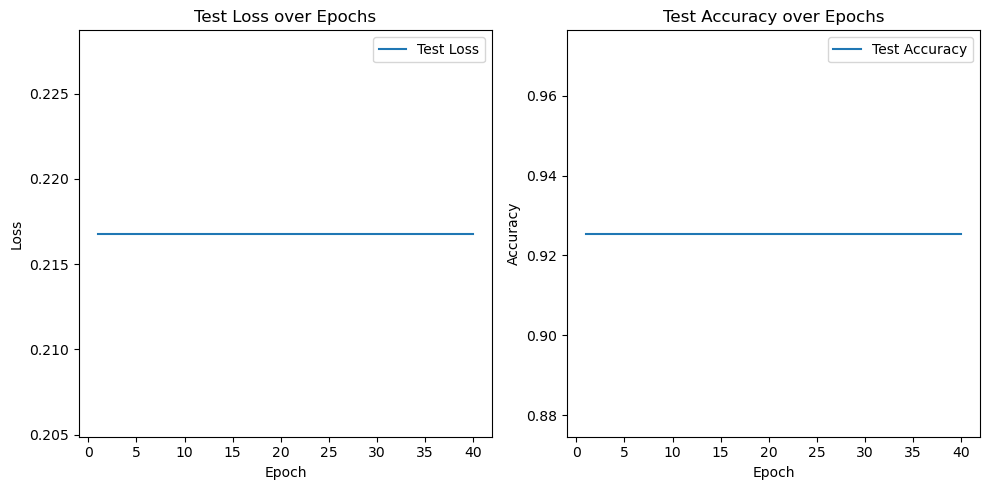

In [31]:
import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy values for plotting
test_losses = []
test_accuracies = []

# Loop over 40 epochs
for epoch in range(1, 41):
    running_loss = 0.0
    running_correct = 0
    model.eval()
    
    # Iterate over batches
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / test_len
    epoch_acc = running_correct.double() / test_len

    print('Epoch {} test loss: {:.4f} test acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))
    
    # Append loss and accuracy values to lists for plotting
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc.item())

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 41), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 41), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


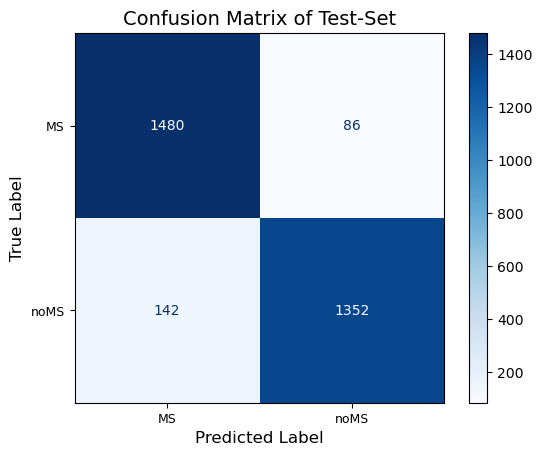

In [25]:
cm_custom = plot_cm(labels, preds, classes, title='Confusion Matrix of Test-Set')